In [ ]:
#https://www.kaggle.com/code/taniaj/cryptocurrency-price-forecasting
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import statsmodels.api as sm
from itertools import product
from math import sqrt
from sklearn.metrics import mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

colors = ["windows blue", "amber", "faded green", "dusty purple"]
sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 18, "axes.labelsize" : 12, 
            "xtick.labelsize" : 14, "ytick.labelsize" : 14 })

import yfinance as yf
import datetime as dt


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


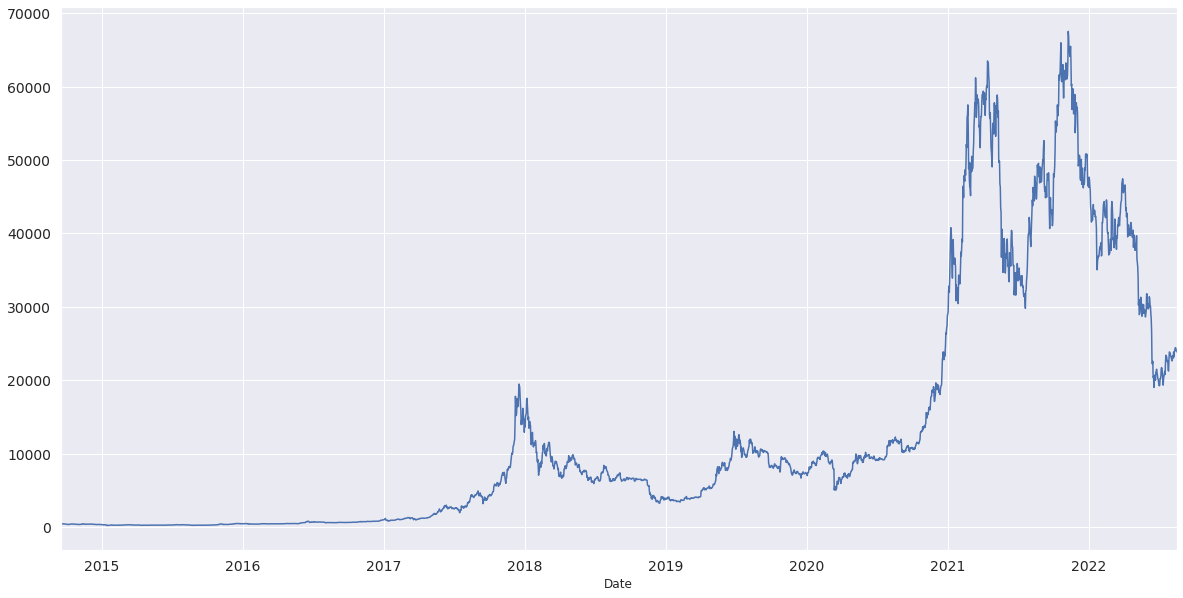

In [ ]:
btc_ticker = yf.Ticker('BTC-USD')
btc = btc_ticker.history(period="max")
btc = btc.drop(columns=['Dividends', 'Stock Splits'])
btc['Open'].plot()

In [ ]:
# df = pd.read_csv('../input/all_currencies.csv', parse_dates=['Date'], index_col='Date', date_parser=dateparse)

In [ ]:
btc.dtypes

Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [ ]:
btc.head()

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


Dickey–Fuller test: p=0.568466


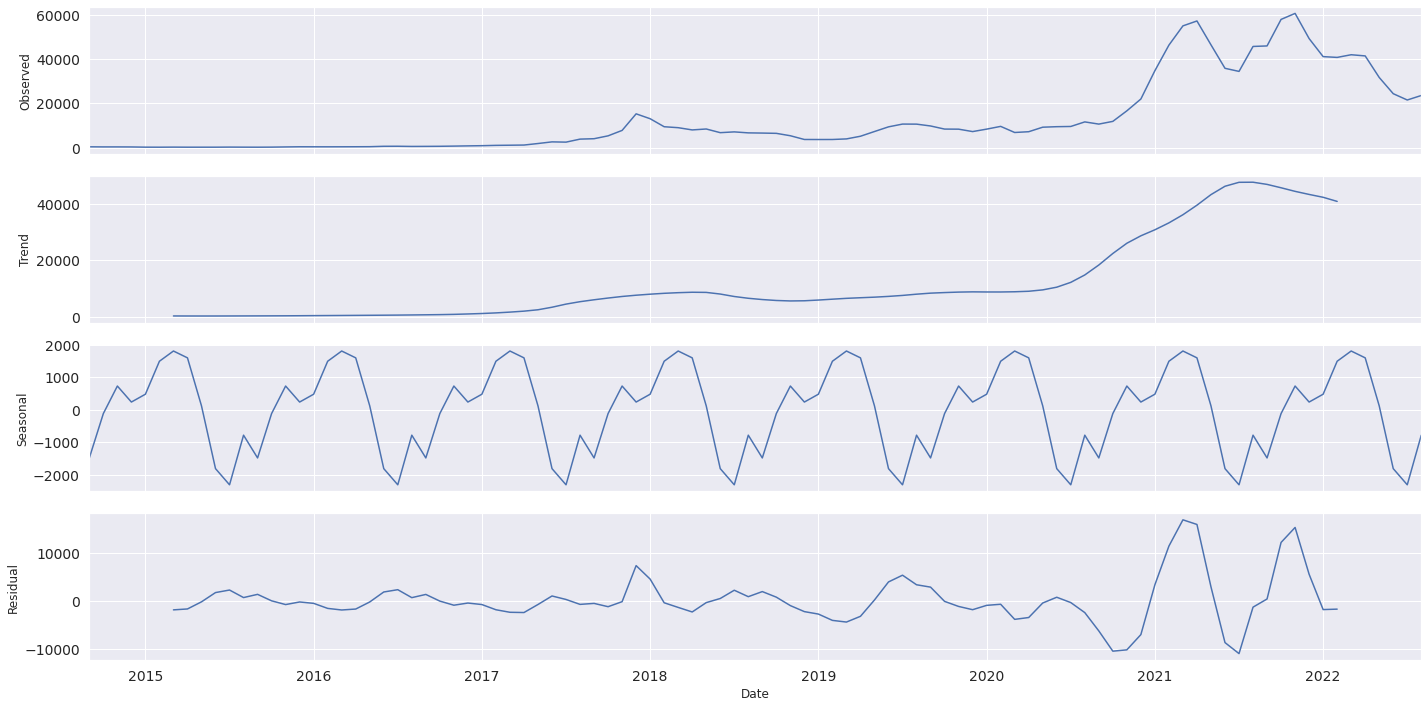

In [ ]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()
seasonal_decompose(btc_month.Close, model='additive').plot()
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.Close)[1])

In [ ]:
btc_month['close_box'], lmbda = stats.boxcox(btc_month.Close)
btc_month.head()

,Open,High,Low,Close,Volume,close_box
Date,,,,,,
2014-09-30,412.654003,421.104422,398.174641,407.182428,2.934864e+07,7.970770
2014-10-31,365.748000,374.314260,354.856645,364.148873,2.912885e+07,7.779929
2014-11-30,364.850235,376.494235,357.241831,366.099799,2.199111e+07,7.789014
2014-12-31,343.074836,347.487129,336.565775,341.267871,1.784201e+07,7.669931
2015-01-31,251.799905,261.391583,240.495550,248.782547,3.544555e+07,7.143244


In [ ]:
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.close_box)[1])

Dickey–Fuller test: p=0.711921


In [ ]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey–Fuller test: p=0.140891


In [ ]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey–Fuller test: p=0.016696


Dickey–Fuller test: p=0.000005


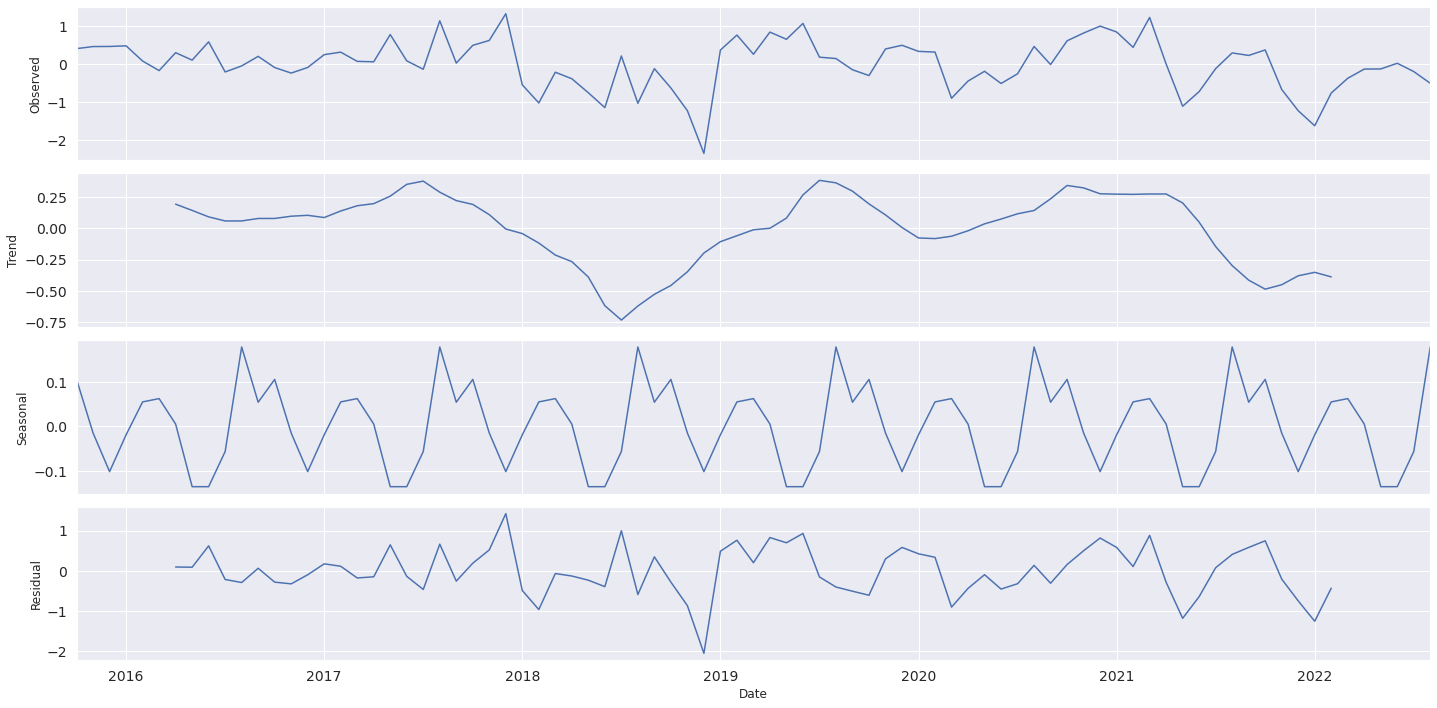

In [ ]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()   
print("Dickey–Fuller test: p=%f" % adfuller(btc_month.box_diff2[13:])[1])

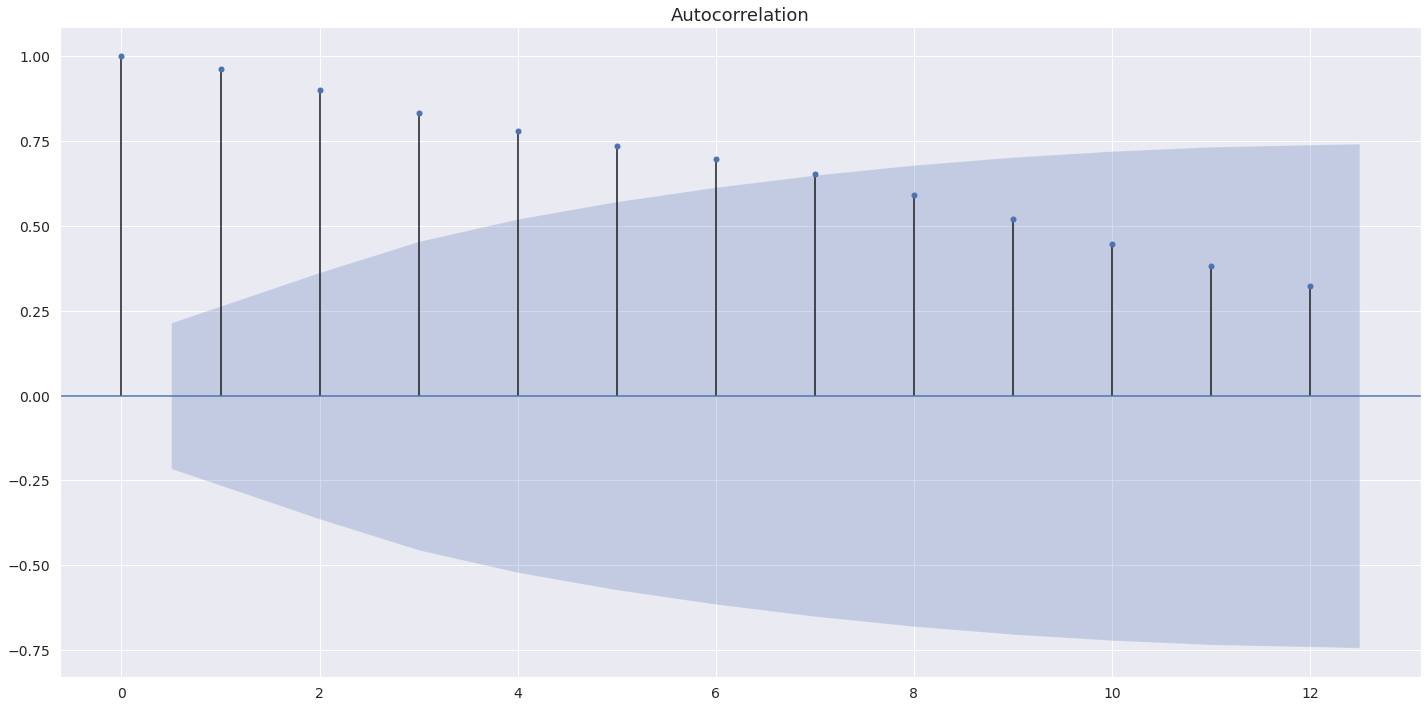

In [ ]:
plot_acf(btc_month.Close[13:].values.squeeze(), lags=12)
plt.tight_layout()

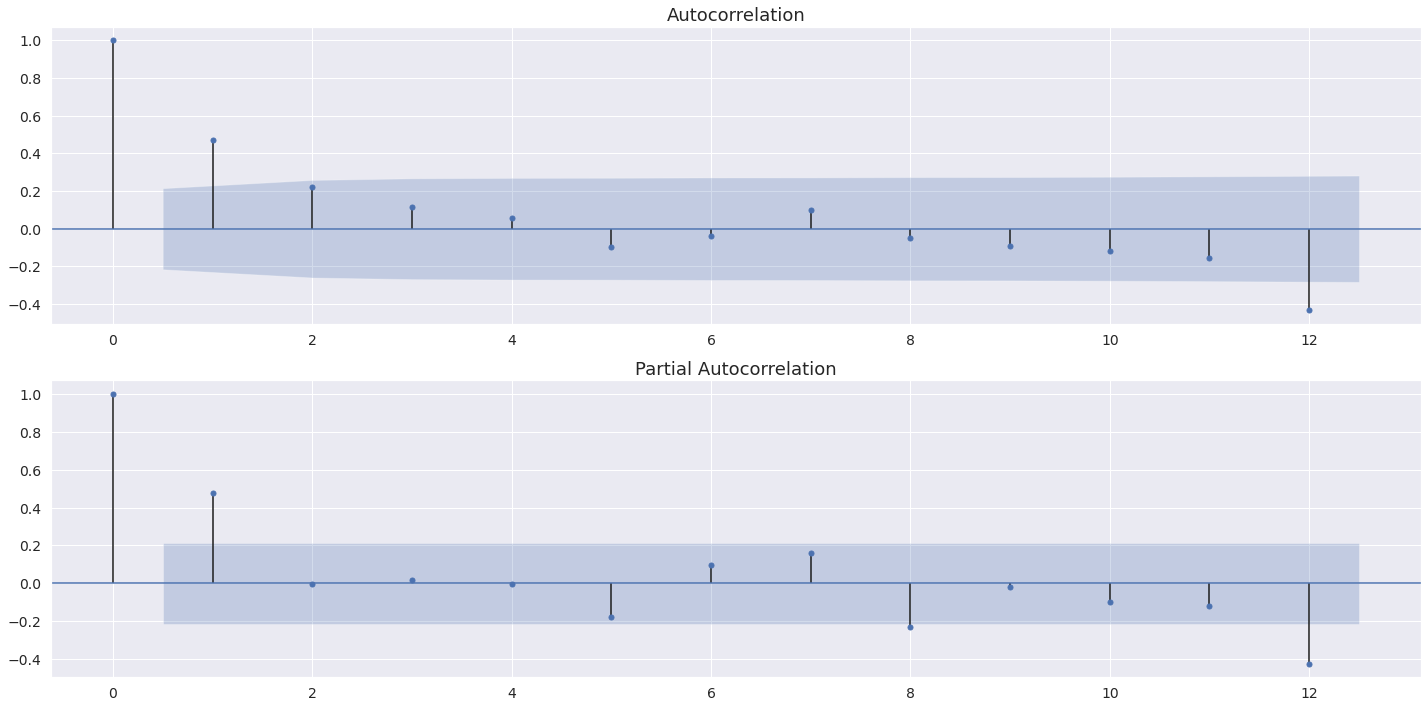

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation function
#sm.graphics.tsa.plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
ax = plt.subplot(212)
#sm.graphics.tsa.plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plot_pacf(btc_month.box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.tight_layout()

In [ ]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters         aic
3     (1, 0)   98.904258
1     (0, 1)   99.810256
4     (1, 1)  100.618256
6     (2, 0)  100.698767
2     (0, 2)  100.979459


In [ ]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:              close_box   No. Observations:                   96
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -47.452
Date:                Wed, 17 Aug 2022   AIC                             98.904
Time:                        12:22:47   BIC                            104.012
Sample:                    09-30-2014   HQIC                           100.968
                         - 08-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4203      0.069      6.091      0.000       0.285       0.556
sigma2         0.1587      0.021      7.509      0.000       0.117       0.200
Ljung-Box (Q):                       36.49   Jarque-

In [ ]:
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

Dickey–Fuller test:: p=0.000000


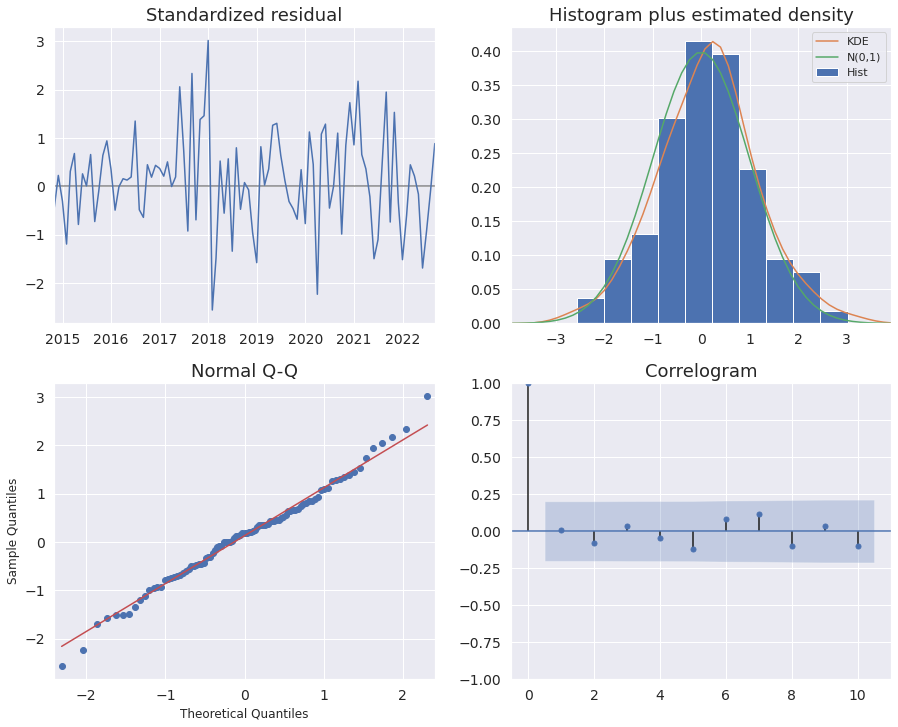

In [ ]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [ ]:
btc2 = btc.copy()
btc2 = btc2.reset_index()
print(btc2.dtypes)
#btc2['Date'] = pd.to_datetime(btc2['Date'], infer_datetime_format=True)
btc2 = btc2.set_index(['Date'])

print(btc2.dtypes)
btc2.head()

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object


,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [ ]:
# Prediction
btc_month_pred = btc_month[['Close']]
date_list = [datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31)]
future = pd.DataFrame(index=date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])
y.head(30)


,Close,Open,High,Low,Volume,close_box,box_diff_seasonal_12,box_diff_seasonal_3,box_diff2
2014-09-30,407.182428,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-31,364.148873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-30,366.099799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-12-31,341.267871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31,248.782547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-28,234.153645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-31,269.042259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-30,235.491534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-31,236.997001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-06-30,238.081766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
btc_month_pred.shape

(99, 9)

In [ ]:
#btc_month_pred['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
print(f'type(best_model): {type(best_model)}')
#2014-09-17
prediction = best_model.predict(start=datetime(2022, 6, 1), end=datetime(2022, 8, 16))


btc_month_pred['forecast'] = invboxcox(prediction, lmbda)

btc_month_pred.Close.plot(linewidth=3)
btc_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close', linewidth=3)
plt.legend()
plt.grid()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')